In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats
import seaborn as sns
import torch
import torch.nn as nn
from scipy import sparse
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"selimaygn","key":"2211657622f8a3e34a1fbcf241a8a719"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d dbdmobile/myanimelist-dataset

100% 1.80G/1.80G [00:21<00:00, 54.5MB/s]
100% 1.80G/1.80G [00:21<00:00, 88.6MB/s]


In [ ]:
! mkdir myanimelist-dataset

In [ ]:
! unzip myanimelist-dataset.zip -d myanimelist-dataset

Archive:  myanimelist-dataset.zip
  inflating: myanimelist-dataset/anime-dataset-2023.csv  
  inflating: myanimelist-dataset/anime-filtered.csv  
  inflating: myanimelist-dataset/final_animedataset.csv  
  inflating: myanimelist-dataset/user-filtered.csv  
  inflating: myanimelist-dataset/users-details-2023.csv  
  inflating: myanimelist-dataset/users-score-2023.csv  


In [ ]:
import os
os.chdir('/content/myanimelist-dataset')


In [ ]:
# Assuming you have a DataFrame named df with an index column
df = pd.read_csv('users-score-2023.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24325191 entries, 0 to 24325190
Data columns (total 5 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   user_id      int64 
 1   Username     object
 2   anime_id     int64 
 3   Anime Title  object
 4   rating       int64 
dtypes: int64(3), object(2)
memory usage: 927.9+ MB


In [ ]:
df = df.drop(['Username', 'Anime Title'], axis=1)

In [ ]:
df.rating.value_counts() # Count of each rating

8     6060484
7     5452152
9     4429914
10    3210021
6     2766482
5     1379480
4      562822
3      233675
2      132092
1       98069
Name: rating, dtype: int64

In [ ]:
df.head()

,user_id,anime_id,rating
0,1,21,9
1,1,48,7
2,1,320,5
3,1,49,8
4,1,304,8


In [ ]:
# Delete users after the 100,000th user id
threshold = 800
df = df[df['user_id'] <= threshold]

# Reset the index of the DataFrame
df = df.reset_index(drop=True)

# Write the updated DataFrame to a new CSV file
df.to_csv('updated_userr_data.csv', index=False)

In [ ]:
df

,user_id,anime_id,rating
0,1,21,9
1,1,48,7
2,1,320,5
3,1,49,8
4,1,304,8
...,...,...,...
48098,797,1221,4
48099,797,232,3
48100,797,859,5
48101,797,690,1


In [ ]:
class AnimeDataset:
    def __init__(self, users, animes, ratings):
        self.users = users
        self.animes = animes
        self.ratings = ratings

    def __len__(self):
        return len(self.users)

    def __getitem__(self, item):
        users = self.users[item]
        animes = self.animes[item]
        ratings = self.ratings[item]

        return {
            'users': torch.tensor(users, dtype=torch.long),
            'animes': torch.tensor(animes, dtype=torch.long),
            'ratings': torch.tensor(ratings, dtype=torch.long),
        }


In [ ]:
class RecSysModel(nn.Module):
    def __init__(self, n_users, n_animes):
        super().__init__()
        # trainable lookup matrix for shallow embedding vectors
        self.user_embed = nn.Embedding(n_users, 32)
        self.anime_embed = nn.Embedding(n_animes, 32)
        # hidden layer
        self.hidden = nn.Linear(64, 32)
        # output layer
        self.out = nn.Linear(32, 1)
        # activation function
        self.activation = nn.ReLU()

    def forward(self, users, animes, ratings=None):
        user_embeds = self.user_embed(users)
        anime_embeds = self.anime_embed(animes)
        x = torch.cat([user_embeds, anime_embeds], dim=1)
        # pass through hidden layer
        x = self.hidden(x)
        x = self.activation(x)
        output = self.out(x)

        return output

In [ ]:
from sklearn import preprocessing, model_selection

# encode the user and anime id to start from 0 so we don't run into index out of bound with Embedding
lbl_user = preprocessing.LabelEncoder()
lbl_anime = preprocessing.LabelEncoder()
df.user_id = lbl_user.fit_transform(df.user_id.values)
df.anime_id = lbl_anime.fit_transform(df.anime_id.values)

df_train, df_valid = model_selection.train_test_split(
    df, test_size=0.1, random_state=42, stratify=df.rating.values
)

train_dataset = AnimeDataset(
    users=df_train.user_id.values,
    animes=df_train.anime_id.values,
    ratings=df_train.rating.values
)

valid_dataset = AnimeDataset(
    users=df_valid.user_id.values,
    animes=df_valid.anime_id.values,
    ratings=df_valid.rating.values
)


In [ ]:

train_loader = DataLoader(dataset=train_dataset,
    batch_size=4,
    num_workers=2)

validation_loader = DataLoader(dataset=valid_dataset,
    batch_size=4,
    num_workers=2)

dataiter = iter(train_loader)
dataloader_data = dataiter.__next__()
print(dataloader_data)


{'users': tensor([219, 148, 153, 112]), 'animes': tensor([4283, 3728,  439,  451]), 'ratings': tensor([8, 9, 8, 6])}


In [ ]:
model = RecSysModel(
    n_users=len(lbl_user.classes_),
    n_animes=len(lbl_anime.classes_),
).to(device)
optimizer = torch.optim.Adam(model.parameters())
sch = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.7)
loss_func = nn.MSELoss()

print(len(lbl_user.classes_))
print(len(lbl_anime.classes_))
print(df.anime_id.max())
print(len(train_dataset))


236
5810
5809
43292


In [ ]:
print(dataloader_data['users'])
print(dataloader_data['users'].size())
print(dataloader_data['animes'])
print(dataloader_data['animes'].size())
user_embed = nn.Embedding(len(lbl_user.classes_), 32)
anime_embed = nn.Embedding(len(lbl_anime.classes_), 32)
out = nn.Linear(64, 1)


tensor([219, 148, 153, 112])
torch.Size([4])
tensor([4283, 3728,  439,  451])
torch.Size([4])


In [ ]:
user_embeds = user_embed(dataloader_data['users'])
anime_embeds = anime_embed(dataloader_data['animes'])
print(f"user_embeds {user_embeds.size()}")
print(f"user_embeds {user_embeds}")

print(f"anime_embeds {anime_embeds.size()}")
print(f"anime_embeds {anime_embeds}")

user_embeds torch.Size([4, 32])
user_embeds tensor([[-0.3251,  0.3353, -0.3637,  0.2465, -0.1960, -0.9632,  1.6926,  1.4058,
          0.6570, -1.7376,  2.0150, -0.3514,  1.0254,  0.9068, -0.3824,  0.1586,
          0.2370,  0.5138,  0.3973,  0.2801, -0.2476, -0.0795, -1.0306,  1.1178,
          1.1902,  1.2711, -0.0895, -1.0493, -0.3827, -0.7957,  1.4933, -1.2286],
        [ 2.1587, -0.4387,  0.0128, -0.4048, -1.2158, -0.9304, -0.7692, -0.7243,
         -0.5725,  0.4232,  1.0663, -0.4102, -0.8984, -0.1411,  0.4718,  0.2453,
          1.5104,  0.3618, -0.0384,  0.7564,  1.8981, -1.0455, -0.7017,  0.3638,
         -0.1137, -0.5155,  1.3155, -0.5152,  1.1457, -0.5372, -1.3169, -2.3833],
        [-1.3951, -0.2399,  0.9798,  0.4603, -0.4096,  0.7480,  1.5816, -0.3328,
          1.0690,  1.7428,  1.2825, -0.1802, -0.0786, -0.5064, -0.0680, -0.2241,
         -0.6549, -0.1813,  0.2172, -1.1393, -0.3796,  0.0616, -0.1430, -0.4901,
          0.6916, -1.0638, -0.2092, -0.5586,  0.8687, -0.3716, 

In [ ]:
output = torch.cat([user_embeds, anime_embeds], dim=1)
print(f"output: {output.size()}")
print(f"output: {output}")
output = out(output)
print(f"output: {output}")

output: torch.Size([4, 64])
output: tensor([[-0.3251,  0.3353, -0.3637,  0.2465, -0.1960, -0.9632,  1.6926,  1.4058,
          0.6570, -1.7376,  2.0150, -0.3514,  1.0254,  0.9068, -0.3824,  0.1586,
          0.2370,  0.5138,  0.3973,  0.2801, -0.2476, -0.0795, -1.0306,  1.1178,
          1.1902,  1.2711, -0.0895, -1.0493, -0.3827, -0.7957,  1.4933, -1.2286,
          0.4034,  0.3106,  0.6807,  0.4948,  0.4996,  0.4766, -0.5311,  0.8023,
         -0.5759,  0.5897,  0.6038,  0.1869, -1.9695, -2.2420, -2.1162, -0.3370,
         -0.3322,  0.5389, -0.4216,  1.8618,  0.9881,  2.5928,  1.4862,  0.7208,
          1.5716,  0.5388,  1.0691,  0.4490,  1.7645, -0.3221,  0.0948, -0.1027],
        [ 2.1587, -0.4387,  0.0128, -0.4048, -1.2158, -0.9304, -0.7692, -0.7243,
         -0.5725,  0.4232,  1.0663, -0.4102, -0.8984, -0.1411,  0.4718,  0.2453,
          1.5104,  0.3618, -0.0384,  0.7564,  1.8981, -1.0455, -0.7017,  0.3638,
         -0.1137, -0.5155,  1.3155, -0.5152,  1.1457, -0.5372, -1.3169, 

In [ ]:
model = model.to(device)
with torch.no_grad():
    model_output = model(dataloader_data['users'],
                         dataloader_data['animes'])
    print(f"model_output: {model_output}, size: {model_output.size()}")

model_output: tensor([[-0.0230],
        [-0.6325],
        [-0.0508],
        [ 0.0754]]), size: torch.Size([4, 1])


In [ ]:
rating = dataloader_data['ratings']
print(rating)
print(rating.view(-1))
print(model_output)

print(rating.sum())

print(model_output.sum() - rating.sum())


tensor([8, 9, 8, 6])
tensor([8, 9, 8, 6])
tensor([[-0.0230],
        [-0.6325],
        [-0.0508],
        [ 0.0754]])
tensor(31)
tensor(-31.6309)


In [ ]:
epochs = 10
total_loss = 0
plot_steps, print_steps = 5000, 5000
step_cnt = 0
all_losses_list = []

model.train()
for epoch_i in range(epochs):
    for i, train_data in enumerate(train_loader):
        output = model(train_data["users"],
                       train_data["animes"]
                      )

        # .view(4, -1) is to reshape the rating to match the shape of model output which is 4x1
        rating = train_data["ratings"].view(4, -1).to(torch.float32)

        loss = loss_func(output, rating)
        total_loss = total_loss + loss.sum().item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        step_cnt = step_cnt + len(train_data["users"])


        if(step_cnt % plot_steps == 0):
            avg_loss = total_loss/(len(train_data["users"]) * plot_steps)
            print(f"epoch {epoch_i} loss at step: {step_cnt} is {avg_loss}")
            all_losses_list.append(avg_loss)
            total_loss = 0 # reset total_loss

epoch 0 loss at step: 2000 is 1.6836917541697622
epoch 0 loss at step: 4000 is 0.22381368218362332
epoch 0 loss at step: 6000 is 0.1634518885728903
epoch 0 loss at step: 8000 is 0.16391209224658088
epoch 0 loss at step: 10000 is 0.15719036934431643
epoch 0 loss at step: 12000 is 0.16123413025494665
epoch 0 loss at step: 14000 is 0.1510040870271623
epoch 0 loss at step: 16000 is 0.13615582848060875
epoch 0 loss at step: 18000 is 0.14405542230885476
epoch 0 loss at step: 20000 is 0.1510769514008425
epoch 0 loss at step: 22000 is 0.14005491666169836
epoch 0 loss at step: 24000 is 0.14351680117240176
epoch 0 loss at step: 26000 is 0.14112303407862783
epoch 0 loss at step: 28000 is 0.1347235747803934
epoch 0 loss at step: 30000 is 0.14386956802196801
epoch 0 loss at step: 32000 is 0.14322830475540832
epoch 0 loss at step: 34000 is 0.13304953653458507
epoch 0 loss at step: 36000 is 0.14134274826094043
epoch 0 loss at step: 38000 is 0.13035025581205265
epoch 0 loss at step: 40000 is 0.1307138

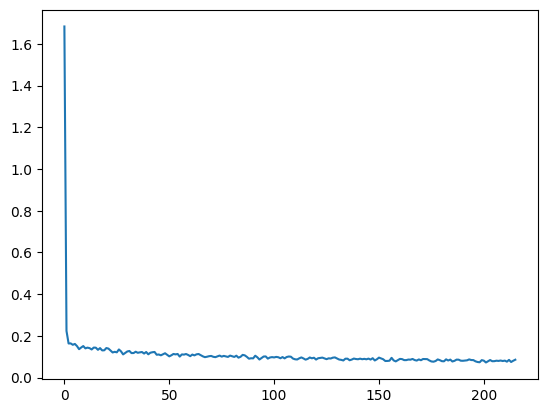

In [ ]:
plt.figure()
plt.plot(all_losses_list)
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error

model_output_list = []
target_rating_list = []

model.eval()

with torch.no_grad():
    for i, batched_data in enumerate(validation_loader):
        model_output = model(batched_data['users'],
                       batched_data["animes"])

        model_output_list.append(model_output.sum().item() / len(batched_data['users']) )

        target_rating = batched_data["ratings"]

        target_rating_list.append(target_rating.sum().item() / len(batched_data['users']))

        print(f"model_output: {model_output}, target_rating: {target_rating}")


# squared If True returns MSE value, if False returns RMSE value.
rms = mean_squared_error(target_rating_list, model_output_list, squared=False)
print(f"rms: {rms}")

model_output: tensor([[8.0639],
        [8.3586],
        [7.2712],
        [7.7996]]), target_rating: tensor([7, 8, 8, 8])
model_output: tensor([[6.2089],
        [7.9881],
        [8.2631],
        [6.4388]]), target_rating: tensor([7, 9, 9, 5])
model_output: tensor([[6.5163],
        [9.6383],
        [6.7337],
        [9.3097]]), target_rating: tensor([ 8, 10,  7,  6])
model_output: tensor([[7.4150],
        [6.4969],
        [6.3768],
        [6.3884]]), target_rating: tensor([7, 8, 7, 6])
model_output: tensor([[7.2138],
        [7.0576],
        [7.5022],
        [5.7916]]), target_rating: tensor([6, 8, 8, 5])
model_output: tensor([[7.1222],
        [6.7432],
        [8.1469],
        [9.2093]]), target_rating: tensor([8, 7, 8, 8])
model_output: tensor([[6.0306],
        [6.2956],
        [7.5823],
        [7.5592]]), target_rating: tensor([5, 7, 7, 6])
model_output: tensor([[7.6745],
        [5.7448],
        [8.3251],
        [7.5664]]), target_rating: tensor([ 7,  8, 10,  3])


In [ ]:
from collections import defaultdict

# a dict that stores a list of predicted rating and actual rating pair for each user
user_est_true = defaultdict(list)

# iterate through the validation data to build the user-> [(y1, y1_hat), (y2, y2_hat)...]
with torch.no_grad():
    for i, batched_data in enumerate(validation_loader):
        users = batched_data['users']
        animes = batched_data['animes']
        ratings = batched_data['ratings']

        model_output = model(batched_data['users'], batched_data["animes"])

        for i in range(len(users)):
            user_id = users[i].item()
            anime_id = animes[i].item()
            pred_rating = model_output[i][0].item()
            true_rating = ratings[i].item()

            print(f"{user_id}, {anime_id}, {pred_rating}, {true_rating}")
            user_est_true[user_id].append((pred_rating, true_rating))


33, 124, 8.063875198364258, 7
199, 60, 8.358626365661621, 8
193, 867, 7.2711896896362305, 8
1, 4502, 7.7996296882629395, 8
20, 1066, 6.208942890167236, 7
84, 3728, 7.988121509552002, 9
210, 2748, 8.263138771057129, 9
216, 167, 6.438809871673584, 5
111, 4993, 6.516317367553711, 8
212, 2504, 9.638263702392578, 10
210, 982, 6.733669281005859, 7
209, 772, 9.309650421142578, 6
61, 2630, 7.414953231811523, 7
156, 743, 6.496890544891357, 8
81, 4953, 6.376847743988037, 7
81, 4668, 6.3884477615356445, 6
96, 2312, 7.213757514953613, 6
84, 2535, 7.057563304901123, 8
81, 357, 7.50219202041626, 8
168, 2851, 5.791645526885986, 5
162, 3546, 7.122175693511963, 8
71, 704, 6.743241310119629, 7
230, 245, 8.146862983703613, 8
226, 701, 9.209311485290527, 8
27, 3968, 6.030610084533691, 5
233, 2133, 6.29558801651001, 7
7, 2056, 7.582315444946289, 7
151, 2229, 7.5591559410095215, 6
153, 2464, 7.674490451812744, 7
123, 798, 5.744808673858643, 8
100, 212, 8.32509708404541, 10
175, 286, 7.5663676261901855, 3
20

In [ ]:
from torch import no_grad

precisions = dict()
recalls = dict()

k=100
threshold=3.5

with no_grad():
    for uid, user_ratings in user_est_true.items():
        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # get the number of actual relevant item
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # get the number of recommended item that are predicted relevant and within topk
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # get the number of recommended item that are also actually relevant within topk
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        print(f"uid {uid}, n_rel {n_rel}, n_rec_k {n_rec_k}, n_rel_and_rec_k {n_rel_and_rec_k}")

        # Precision@k: Proportion of recommended items that are relevant
        # when number of recommended item is undefined. We here set it to 0.
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@k: Proportion or recommended items that are recommended
        # When n_rel is 0; Recall is undefined. We here set it to 0.
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0


uid 33, n_rel 11, n_rec_k 11, n_rel_and_rec_k 11
uid 199, n_rel 26, n_rec_k 28, n_rel_and_rec_k 26
uid 193, n_rel 39, n_rec_k 40, n_rel_and_rec_k 39
uid 1, n_rel 23, n_rec_k 25, n_rel_and_rec_k 23
uid 20, n_rel 14, n_rec_k 15, n_rel_and_rec_k 14
uid 84, n_rel 15, n_rec_k 15, n_rel_and_rec_k 15
uid 210, n_rel 41, n_rec_k 41, n_rel_and_rec_k 41
uid 216, n_rel 14, n_rec_k 14, n_rel_and_rec_k 14
uid 111, n_rel 182, n_rec_k 100, n_rel_and_rec_k 99
uid 212, n_rel 27, n_rec_k 29, n_rel_and_rec_k 27
uid 209, n_rel 18, n_rec_k 18, n_rel_and_rec_k 18
uid 61, n_rel 50, n_rec_k 50, n_rel_and_rec_k 50
uid 156, n_rel 78, n_rec_k 81, n_rel_and_rec_k 78
uid 81, n_rel 161, n_rec_k 100, n_rel_and_rec_k 100
uid 96, n_rel 31, n_rec_k 31, n_rel_and_rec_k 31
uid 168, n_rel 108, n_rec_k 100, n_rel_and_rec_k 100
uid 162, n_rel 80, n_rec_k 81, n_rel_and_rec_k 80
uid 71, n_rel 6, n_rec_k 7, n_rel_and_rec_k 6
uid 230, n_rel 35, n_rec_k 36, n_rel_and_rec_k 35
uid 226, n_rel 37, n_rec_k 39, n_rel_and_rec_k 37
uid 

In [ ]:
# Precision and recall can then be averaged over all users
precision = sum(prec for prec in precisions.values()) / len(precisions)
recall = sum(rec for rec in recalls.values()) / len(recalls)
print(f"precision @ {k}: {sum(prec for prec in precisions.values()) / len(precisions)}")
print(f"recall @ {k}: {sum(rec for rec in recalls.values()) / len(recalls)}")

f1_score = 2 * (precision * recall) / (precision + recall)
print(f"F1 score @ {k}: {f1_score}")

precision @ 100: 0.9832076557038668
recall @ 100: 0.9951568960424356
F1 score @ 100: 0.98914618941362


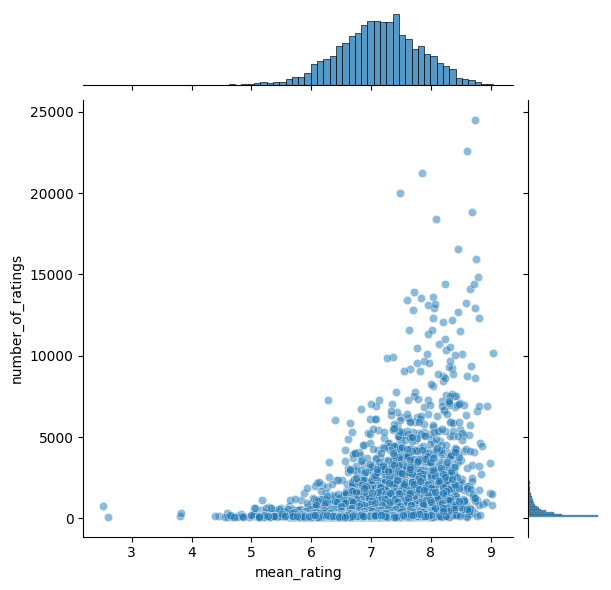

In [ ]:
sns.jointplot(x='mean_rating', y='number_of_ratings', data=agg_ratings_GT200, alpha=0.5)